<a href="https://colab.research.google.com/github/Destructor169/cs-203-stt-ai/blob/main/assignments/assignment2_stt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: The "Smart Labeling Pipeline" Challenge

**Total Marks: 20**

Build a cost-effective, high-quality labeling pipeline using human annotation, programmatic rules, and LLMs.

This notebook implements an end-to-end smart labeling pipeline to:
1. Establish gold standard through human annotation and measure inter-annotator agreement (6 marks)
2. Label data programmatically using weak supervision (Snorkel) (6 marks)
3. Optimize labeling budget using active learning (5 marks)
4. Leverage LLMs for bulk labeling and detect hallucinations (e.g. noisy labels) (3 marks)

## Setup and Imports

In [ ]:
!pip install snorkel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 9.4 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel
from statsmodels.stats.inter_rater import fleiss_kappa
import google.generativeai as genai
import time
from pathlib import Path
import re

/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


## Task 1: The Human as Annotator (6 Marks)

**Objective:** Establish a "Gold Standard" dataset and measure human consensus.

### Part 1.1: Parse Annotator CSV Files

After annotating the first 100 reviews, export annotations from three annotators (A, B, C) as CSV files.
Parse these CSV files into clean DataFrames for analysis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive/dataset/STT"

Mounted at /content/drive


In [ ]:
def parse_annotator_csv(csv_path):
    """
    Parses annotator CSV file into a clean DataFrame.

    Args:
        csv_path (str): Path to annotator CSV file

    Returns:
        pd.DataFrame: DataFrame with columns ['review_id', 'review', 'label']
                     where label is one of: 'Positive', 'Negative', 'Neutral'

    Note:
        - Look for relevant column names in the CSV file
        - If column names differ, the function will try to map them appropriately
        - Finally, return with two columns 'review' and 'label'
    """
    df = pd.read_csv(csv_path)

    # Case 1: Label Studio exports label directly
    if {'review', 'sentiment'}.issubset(df.columns):
        out = df[['review', 'sentiment']].copy()
        out.columns = ['review', 'label']

    # Case 2: Label stored inside annotation_result JSON
    elif 'annotation_result' in df.columns:
        reviews = []
        labels = []

        for _, row in df.iterrows():
            annotation = json.loads(row['annotation_result'])
            label = annotation[0]['value']['choices'][0]
            reviews.append(row['review'])
            labels.append(label)

        out = pd.DataFrame({
            'review': reviews,
            'label': labels
        })

    else:
        raise ValueError("Unrecognized Label Studio CSV format")

    out['review_id'] = range(len(out))
    return out[['review_id', 'review', 'label']]

In [ ]:
# TODO: Parse CSV files (replace with actual file paths)

df_a = parse_annotator_csv(f"{BASE_PATH}/annotator_a.csv")
df_b = parse_annotator_csv(f"{BASE_PATH}/annotator_b.csv")
df_c = parse_annotator_csv(f"{BASE_PATH}/annotator_c.csv")

# Display sample data
df_a.head()

,review_id,review,label
0,0,This movie is a triumph in every sense. Highly...,Positive
1,1,I have never been so bored in my life. The sco...,Negative
2,2,I was completely blown away by this film. The ...,Positive
3,3,The trailer was better than the movie. The act...,Negative
4,4,Middle of the road entertainment. Visually it'...,Neutral


### Part 1.2: Implement Fleiss' Kappa from Scratch

Measure inter-annotator agreement using Fleiss' Kappa statistic.
Implement the formula from scratch and compare with statsmodels implementation.

In [ ]:
def fleiss_kappa_scratch(rating_matrix):
    """
    Computes Fleiss' Kappa for multiple raters from scratch.

    Args:
        rating_matrix (np.array): A Count Matrix of shape (N, k).
                                  - N = number of items (rows)
                                  - k = number of categories (columns)
                                  - Element [i, j] = Count of raters who assigned category j to item i.
                                  Example:
                                    [[0, 0, 3],   # Item 0: All 3 raters said Category 2
                                     [1, 2, 0]]   # Item 1: 1 rater said Cat 0, 2 said Cat 1


    Returns:
        float: Kappa score (ranges from -1 to 1, where 1 = perfect agreement)

    Formula:
        κ = (P_bar - P_e_bar) / (1 - P_e_bar)

        where:
        - P_bar = (1/N) * Σ(P_i) = average proportion of agreement across all items
        - P_i = (1/(n*(n-1))) * Σ(k_ij * (k_ij - 1)) for item i
        - P_e_bar = Σ(p_j^2) = expected agreement by chance
        - p_j = proportion of all assignments to category j

    Note:
        - N = number of items (samples)
        - n = number of raters per item (should be constant)
        - k_ij = number of raters who assigned category j to item i
    """
    N, k = rating_matrix.shape
    n = np.sum(rating_matrix[0])  # number of raters

    # Calculate P_i for each item
    P_i = []
    for i in range(N):
        row = rating_matrix[i]
        P_i.append(np.sum(row * (row - 1)) / (n * (n - 1)))

    P_bar = np.mean(P_i)

    # Calculate p_j for each category
    p_j = np.sum(rating_matrix, axis=0) / (N * n)
    P_e_bar = np.sum(p_j ** 2)

    # Apply Fleiss' Kappa formula
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    return kappa

In [ ]:
def prepare_rating_matrix(df_a, df_b, df_c):
    """
    Converts three DataFrames into a rating matrix for Fleiss' Kappa calculation.

    Args:
        df_a, df_b, df_c: DataFrames with columns ['review_id', 'review', 'label']

    Returns:
        np.array: Rating matrix of shape (N_samples, N_categories)
                  where categories are ['Negative', 'Neutral', 'Positive']
    """
    # TODO: Merge the three DataFrames on review
    # Hint: Use pd.merge() or pd.concat() with proper keys

    merged = df_a.merge(df_b, on='review_id', suffixes=('_a', '_b'))
    merged = merged.merge(df_c, on='review_id')
    merged.rename(columns={'label': 'label_c'}, inplace=True)

    label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
    rating_matrix = np.zeros((len(merged), 3), dtype=int)

    for i, row in merged.iterrows():
        labels = [row['label_a'], row['label_b'], row['label_c']]
        for label in labels:
            rating_matrix[i, label_map[label]] += 1

    # TODO: Return numpy array of shape (N_samples, 3)
    # Order: [Negative_count, Neutral_count, Positive_count] for each row
    return rating_matrix

In [ ]:
# TODO: Prepare rating matrix and calculate Fleiss' Kappa

rating_matrix = prepare_rating_matrix(df_a, df_b, df_c)

kappa_scratch = fleiss_kappa_scratch(rating_matrix)
kappa_statsmodels = fleiss_kappa(rating_matrix)

# TODO: Print the difference between the two implementations
print(f"Fleiss' Kappa (Scratch): {kappa_scratch:.4f}")
print(f"Fleiss' Kappa (Statsmodels): {kappa_statsmodels:.4f}")
print(f"Difference: {abs(kappa_scratch - kappa_statsmodels):.6f}")

Fleiss' Kappa (Scratch): 0.8159
Fleiss' Kappa (Statsmodels): 0.8159
Difference: 0.000000


### Part 1.3: Conflict Resolution

Identify conflicts where annotators disagree and resolve them using majority vote.
For complete ties (all three differ), default to 'Neutral'.

In [ ]:
def resolve_conflicts(df_a, df_b, df_c):
    """
    Merges annotations from 3 annotators, resolves disagreements using Majority Vote,
    and handles complete ties by defaulting to 'Neutral'.

    Args:
        df_a, df_b, df_c: DataFrames from each annotator with columns ['review', 'label']

    Returns:
        pd.DataFrame: Final DataFrame with resolved labels (gold standard)
                     Columns: ['review', 'label']

    Logic:
        - Majority Vote: If 2 annotators agree, use their label
        - Tie-Breaker: If all 3 differ (e.g., Positive vs. Negative vs. Neutral), assign 'Neutral'
    """
    merged = df_a.merge(df_b, on='review_id', suffixes=('_a', '_b'))
    merged = merged.merge(df_c, on='review_id')
    merged.rename(columns={'label': 'label_c'}, inplace=True)

    final_labels = []

    for _, row in merged.iterrows():
        labels = [row['label_a'], row['label_b'], row['label_c']]
        counts = pd.Series(labels).value_counts()

        if counts.iloc[0] >= 2:
            final_labels.append(counts.index[0])
        else:
            final_labels.append('Neutral')

    merged['label'] = final_labels
    return merged[['review', 'label']]

In [ ]:
# TODO: Display 5 examples of conflicting reviews (if <5 reviews, show all)
# Show what A, B, and C each said, and the final resolved label

conflicts = df_a.merge(df_b, on='review_id', suffixes=('_a', '_b'))
conflicts = conflicts.merge(df_c, on='review_id')
conflicts.rename(columns={'label': 'label_c'}, inplace=True)

conflicts = conflicts[
    ~(
        (conflicts['label_a'] == conflicts['label_b']) &
        (conflicts['label_b'] == conflicts['label_c'])
    )
]

conflicts[['review', 'label_a', 'label_b', 'label_c']].head(5)

,review,label_a,label_b,label_c
10,I oscillated between loving and hating this fi...,Neutral,Positive,Neutral
20,I have mixed feelings about this one. You won'...,Neutral,Negative,Neutral
29,"Great concept, but the execution was jarring. ...",Neutral,Positive,Neutral
30,"Ideally, this should have been great, but some...",Neutral,Negative,Neutral
32,This is a very difficult movie to categorize. ...,Neutral,Negative,Neutral


In [ ]:
# TODO: Save gold standard to CSV

gold_standard_df = resolve_conflicts(df_a, df_b, df_c)
gold_standard_df.to_csv(f"{BASE_PATH}/gold_standard_100.csv", index=False)

gold_standard_df.head()

,review,label
0,This movie is a triumph in every sense. Highly...,Positive
1,I have never been so bored in my life. The sco...,Negative
2,I was completely blown away by this film. The ...,Positive
3,The trailer was better than the movie. The act...,Negative
4,Middle of the road entertainment. Visually it'...,Neutral


## Task 2: Weak Supervision (The "Lazy" Labeler) (6 Marks)

**Objective:** Label the next 200 reviews programmatically to save time.

### Part 2.1: Heuristic Development

Analyze patterns in the gold standard and write at least 3 heuristic functions.
Apply them to the remaining 200 unlabeled reviews.

In [ ]:
# Constants for labeling functions
POSITIVE = 1
NEGATIVE = 0
NEUTRAL = 2
ABSTAIN = -1

# TODO: Load gold standard to analyze patterns
gold_df = pd.read_csv("/content/drive/MyDrive/dataset/STT/gold_standard_100.csv")

# TODO: Analyze patterns (e.g., common positive/negative words, review length, etc.)
# This will help you design effective heuristics

gold_df['label'].value_counts()

,count
label,
Neutral,49
Positive,27
Negative,24


### Part 2.2: Snorkel Labeling Functions

Wrap your heuristics as Snorkel @labeling_function decorators.
Each function should return POSITIVE (1), NEGATIVE (0), NEUTRAL (2), or ABSTAIN (-1).

In [ ]:
@labeling_function()
def lf_keyword_great(x):
    """
    Example labeling function: Check if "great" appears in the review.
    Returns POSITIVE if found, otherwise ABSTAIN.
    """
    # TODO: Check if "great" (case-insensitive) is in x.review
    # Return POSITIVE if found, ABSTAIN otherwise
    if "great" in x.review.lower():
        return POSITIVE
    return ABSTAIN


@labeling_function()
def lf_short_review(x):
    """
    Label based on review length.
    Very short reviews might be neutral or indicate lack of engagement.
    """
    # TODO: Implement logic based on review length
    # Return appropriate label (NEUTRAL for very short, or ABSTAIN)
    if len(x.review.split()) < 8:
        return NEUTRAL
    return ABSTAIN


@labeling_function()
def lf_regex_bad(x):
    """
    Use regex to find negative patterns.
    Look for words like "horrible", "terrible", "awful", etc.
    """
    # TODO: Use regex or string matching to find negative keywords
    # Return NEGATIVE if found, ABSTAIN otherwise
    if re.search(r"horrible|terrible|awful|garbage|train wreck|worst", x.review.lower()):
        return NEGATIVE
    return ABSTAIN


# TODO: Write at least 3 more labeling functions (minimum 6 total)

@labeling_function()
def lf_strong_positive_phrases(x):
    if re.search(r"must-watch|two thumbs up|cinema at its finest|highly recommended|10/10", x.review.lower()):
        return POSITIVE
    return ABSTAIN


@labeling_function()
def lf_strong_negative_phrases(x):
    if re.search(r"avoid this|zero stars|do not bother|hard pass|waste of potential", x.review.lower()):
        return NEGATIVE
    return ABSTAIN


@labeling_function()
def lf_mixed_feelings(x):
    if re.search(r"mixed feelings|not a masterpiece|not a disaster|it was fine|middle of the road", x.review.lower()):
        return NEUTRAL
    return ABSTAIN

### Part 2.3: Apply Labeling Functions and Analyze Coverage

Apply all labeling functions to the 200 unlabeled reviews and calculate coverage and conflict rates.

In [ ]:
def analyze_weak_labels(L_matrix, lfs):
    """
    Prints Coverage and Conflict statistics for the Labeling Functions.

    Args:
        L_matrix (np.array): Label matrix of shape (N_samples, N_functions)
                            Each column represents one labeling function's outputs
                            Values: POSITIVE (1), NEGATIVE (0), NEUTRAL (2), ABSTAIN (-1)
        lfs: List of labeling functions (for display names)

    Metrics to calculate:
        - Coverage: Percentage of non-abstain votes per LF
        - Conflict Rate: Percentage of samples where LFs disagree
    """
    # TODO: Calculate coverage for each labeling function
    # Coverage = (number of non-abstain votes) / (total samples) * 100

    N, M = L_matrix.shape
    print("=== Coverage per Labeling Function ===")
    for j in range(M):
        coverage = np.sum(L_matrix[:, j] != ABSTAIN) / N * 100
        print(f"{lfs[j].name}: {coverage:.2f}%")

    # TODO: Calculate conflict rate
    # Conflict occurs when multiple LFs label the same sample differently
    # Conflict Rate = (number of conflicting samples) / (total samples) * 100

    conflicts = 0
    for i in range(N):
        active = L_matrix[i][L_matrix[i] != ABSTAIN]
        if len(active) > 1 and len(set(active)) > 1:
            conflicts += 1

    conflict_rate = conflicts / N * 100
    print(f"\nConflict Rate: {conflict_rate:.2f}%")

    # TODO: Print statistics in a readable format
    # Hint: Use LFAnalysis from snorkel for detailed stats (optional)
    # Or print manually: LF name, Coverage %, Conflicts count


# TODO: Load the 200 unlabeled reviews (you can load the entire dataset and then filter as per the requirement)

full_df = pd.read_csv("/content/drive/MyDrive/dataset/STT/Movie_reviews.csv")
unlabeled_df = full_df.iloc[100:].reset_index(drop=True)


# TODO: Apply all labeling functions to create L_matrix
# lfs = [lf_keyword_great, lf_short_review, lf_regex_bad, ...]  # Add all your LFs
# applier = <put your code here>
# L_matrix = <put your code here>

lfs = [
    lf_keyword_great,
    lf_short_review,
    lf_regex_bad,
    lf_strong_positive_phrases,
    lf_strong_negative_phrases,
    lf_mixed_feelings
]

applier = PandasLFApplier(lfs=lfs)
L_matrix = applier.apply(unlabeled_df)


# TODO: Analyze coverage and conflicts
analyze_weak_labels(L_matrix, lfs)


# TODO: Use LFAnalysis for detailed statistics
LFAnalysis(L=L_matrix, lfs=lfs).lf_summary()

100%|██████████| 220/220 [00:00<00:00, 11656.14it/s]

=== Coverage per Labeling Function ===
lf_keyword_great: 5.00%
lf_short_review: 0.91%
lf_regex_bad: 11.82%
lf_strong_positive_phrases: 7.73%
lf_strong_negative_phrases: 8.64%
lf_mixed_feelings: 9.09%

Conflict Rate: 0.91%


,j,Polarity,Coverage,Overlaps,Conflicts
lf_keyword_great,0,[1],0.050000,0.000000,0.000000
lf_short_review,1,[2],0.009091,0.009091,0.009091
lf_regex_bad,2,[0],0.118182,0.018182,0.009091
lf_strong_positive_phrases,3,[1],0.077273,0.000000,0.000000
lf_strong_negative_phrases,4,[0],0.086364,0.013636,0.004545
lf_mixed_feelings,5,[2],0.090909,0.000000,0.000000


### Part 2.4: Majority Vote Adjudication

Use majority vote to generate probabilistic labels (weak labels) for the 200 reviews.
Save the result to `weak_labels_200.csv`.

In [ ]:
# TODO: Train LabelModel to get probabilistic labels

label_model = LabelModel(cardinality=3, verbose=False)
label_model.fit(L_train=L_matrix, n_epochs=500, lr=0.01)


# TODO: Convert numeric labels to match your label scheme
# Label mapping: 0 -> 'Negative' (or 0), 1 -> 'Positive' (or 1), 2 -> 'Neutral' (or 2), -1 -> 'Abstain'

preds = label_model.predict(L=L_matrix)

label_map = {
    0: "Negative",
    1: "Positive",
    2: "Neutral",
    -1: "Neutral"   # Treat abstain as Neutral
}

pred_labels = [label_map[int(p)] for p in preds]


# TODO: Create DataFrame with reviews and weak labels

weak_labels_df = pd.DataFrame({
    "review": unlabeled_df["review"],
    "weak_label": pred_labels
})


# TODO: Save to CSV

weak_labels_df.to_csv(
    "/content/drive/MyDrive/dataset/STT/weak_labels_200.csv",
    index=False
)

weak_labels_df.head()

100%|██████████| 500/500 [00:00<00:00, 620.89epoch/s]


,review,weak_label
0,It’s a weird mix of brilliance and stupidity. ...,Positive
1,I struggled to sit through the first half. Not...,Negative
2,I struggled to sit through the first half. The...,Negative
3,I'm honestly still trying to process what I ju...,Neutral
4,A refreshing take on a tired genre. It perfect...,Positive


## Task 3: Active Learning (The Budget Optimizer) (5 Marks)

**Objective:** Simulate cost savings by training a model iteratively.

### Part 3.1: Query Strategy Implementation

Implement Least Confidence and Entropy Sampling from scratch.
These strategies select the most informative samples for labeling.

In [ ]:
def least_confidence_sampling(model, X_pool, n_instances=10):
    """
    Selects samples where the model is least confident (uncertainty sampling).
    """
    probs = model.predict_proba(X_pool)
    uncertainty = 1 - np.max(probs, axis=1)
    return np.argsort(uncertainty)[-n_instances:]


def entropy_sampling(model, X_pool, n_instances=10):
    """
    Selects samples with highest entropy (information gain).
    """
    probs = model.predict_proba(X_pool)
    epsilon = 1e-9
    entropy = -np.sum(probs * np.log(probs + epsilon), axis=1)
    return np.argsort(entropy)[-n_instances:]


def random_sampling(model, X_pool, n_instances=10):
    """
    Baseline random sampling strategy.
    """
    if n_instances > X_pool.shape[0]:
        n_instances = X_pool.shape[0]
    return np.random.choice(X_pool.shape[0], size=n_instances, replace=False)

### Part 3.2: Data Processing and Setup

Load the gold standard (seed) and weak labels (pool).
Create a static test set from the pool for evaluation.
Vectorize text data using TF-IDF.

In [ ]:
def load_and_process_data():
    """
    Loads gold standard and weak labels using YOUR column names.
    Compatible with:
      - gold_standard_100.csv → column: 'label'
      - weak_labels_200.csv → column: 'weak_label'
    """
    import os

    BASE_PATH = "/content/drive/MyDrive/dataset/STT"

    seed_path = os.path.join(BASE_PATH, "gold_standard_100.csv")
    pool_path = os.path.join(BASE_PATH, "weak_labels_200.csv")

    if not os.path.exists(seed_path):
        raise FileNotFoundError("gold_standard_100.csv not found")

    if not os.path.exists(pool_path):
        raise FileNotFoundError("weak_labels_200.csv not found")

    df_seed = pd.read_csv(seed_path)
    df_pool_full = pd.read_csv(pool_path)

    # -------- Column contract enforcement --------
    if 'label' not in df_seed.columns:
        raise ValueError("Gold standard must contain 'label' column")

    if 'weak_label' in df_pool_full.columns:
        pool_label_col = 'weak_label'
    elif 'label' in df_pool_full.columns:
        pool_label_col = 'label'
    else:
        raise ValueError("Pool must contain 'weak_label' or 'label'")
    # --------------------------------------------

    label_mapping = {
        'Negative': 0, 'negative': 0,
        'Positive': 1, 'positive': 1,
        'Neutral': 2, 'neutral': 2,
        0: 0, 1: 1, 2: 2
    }

    df_seed['sentiment_numeric'] = df_seed['label'].map(label_mapping).astype(int)
    df_pool_full['sentiment_numeric'] = df_pool_full[pool_label_col].map(label_mapping).astype(int)

    # Create test split from pool
    df_pool, df_test = train_test_split(
        df_pool_full, test_size=50, random_state=42
    )

    # Vectorization
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    vectorizer.fit(
        pd.concat([
            df_seed['review'],
            df_pool['review'],
            df_test['review']
        ]).fillna("")
    )

    X_seed = vectorizer.transform(df_seed['review'].fillna("")).toarray()
    y_seed = df_seed['sentiment_numeric'].values

    X_pool = vectorizer.transform(df_pool['review'].fillna("")).toarray()
    y_pool = df_pool['sentiment_numeric'].values

    X_test = vectorizer.transform(df_test['review'].fillna("")).toarray()
    y_test = df_test['sentiment_numeric'].values

    return X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer


# Load data
X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer = load_and_process_data()

print(f"Seed size: {len(y_seed)}")
print(f"Pool size: {len(y_pool)}")
print(f"Test size: {len(y_test)}")

Seed size: 100
Pool size: 170
Test size: 50


### Part 3.3: Active Learning Loop

Implement the iterative active learning loop:
1. Train model on current training set
2. Query uncertain samples from pool
3. "Label" them (reveal ground truth)
4. Add to training set and retrain
5. Log test accuracy

In [ ]:
def run_active_learning_loop(X_seed, y_seed, X_pool, y_pool, X_test, y_test,
                             strategy_func, steps=5, batch_size=10):
    """
    Active learning loop simulation.
    """
    X_train = X_seed.copy()
    y_train = y_seed.copy()

    X_pool_curr = X_pool.copy()
    y_pool_curr = y_pool.copy()

    accuracy_history = []
    n_labels_history = []

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    acc = accuracy_score(y_test, model.predict(X_test))
    accuracy_history.append(acc)
    n_labels_history.append(len(y_train))

    for _ in range(steps):
        if len(y_pool_curr) == 0:
            break

        query_idx = strategy_func(model, X_pool_curr, batch_size)

        X_new = X_pool_curr[query_idx]
        y_new = y_pool_curr[query_idx]

        X_train = np.vstack([X_train, X_new])
        y_train = np.concatenate([y_train, y_new])

        mask = np.ones(len(y_pool_curr), dtype=bool)
        mask[query_idx] = False
        X_pool_curr = X_pool_curr[mask]
        y_pool_curr = y_pool_curr[mask]

        model.fit(X_train, y_train)
        acc = accuracy_score(y_test, model.predict(X_test))

        accuracy_history.append(acc)
        n_labels_history.append(len(y_train))

    return n_labels_history, accuracy_history


# Run Least Confidence Sampling
n_labels_lc, acc_lc = run_active_learning_loop(
    X_seed, y_seed, X_pool, y_pool, X_test, y_test,
    least_confidence_sampling
)

### Part 3.4: Visualization and Comparison

Plot learning curves comparing Active Learning vs. Random Sampling.

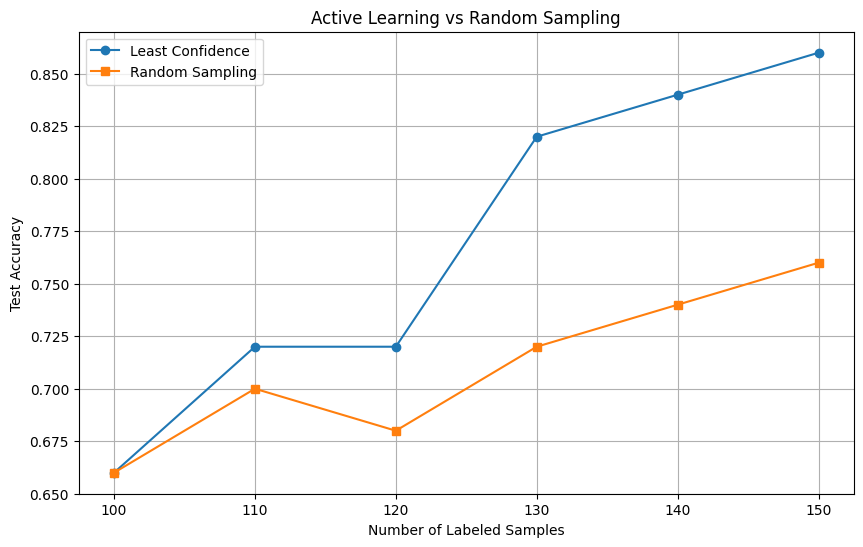

Final Accuracy (Least Confidence): 0.8600
Final Accuracy (Random Sampling): 0.7600


In [ ]:
# Run Random Sampling
n_labels_random, acc_random = run_active_learning_loop(
    X_seed, y_seed, X_pool, y_pool, X_test, y_test,
    random_sampling
)

# Plot Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(n_labels_lc, acc_lc, marker='o', label='Least Confidence')
plt.plot(n_labels_random, acc_random, marker='s', label='Random Sampling')
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Test Accuracy")
plt.title("Active Learning vs Random Sampling")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Accuracy (Least Confidence): {acc_lc[-1]:.4f}")
print(f"Final Accuracy (Random Sampling): {acc_random[-1]:.4f}")

## Task 4: AI vs. AI (LLM & Noise Detection) (3 Marks)

**Objective:** Use LLMs for bulk labeling and detect hallucinations.

**Note:**

- Make an account at [open-router](https://openrouter.ai/) and get the API key.
- Use `google/gemini-2.5-flash-lite` (free tier) model as your LLM. Read the documentation on how to use it [here](https://openrouter.ai/google/gemini-2.5-flash-lite/api)
- Set environment variable using .env file and paste your API key in it.

### Part 4.1: LLM Pipeline with Few-Shot Prompting

Design a few-shot prompt with 3 examples from gold standard.
Send remaining unlabeled samples (~150) to Gemini API for labeling.

In [ ]:
from google.colab import userdata

API_KEY = userdata.get("OPENROUTER_API_KEY")

print(API_KEY is not None)

True


In [ ]:
import os
import time
import json
import requests
import pandas as pd
from google.colab import drive, userdata

API_KEY = userdata.get("OPENROUTER_API_KEY")
SITE_URL = "http://localhost:8000"  #for OpenRouter rankings
SITE_NAME = "Student Lab Assignment"

MODEL_NAME = "google/gemini-2.5-flash-lite"

if not API_KEY:
    print("⚠ Warning: OPENROUTER_API_KEY not found. Please check your .env file.")


def generate_few_shot_prompt(review_text, examples):
    """
    Constructs a few-shot prompt with 3 gold examples + target review.

    Args:
        review_text (str): The review to be labeled
        examples (list): List of 3 example dictionaries with 'review' and 'label' keys

    Returns:
        str: Formatted prompt string
    """
    prompt = "Classify the sentiment of the following movie reviews as Positive, Negative, or Neutral.\n\n"
    for ex in examples:
        prompt += f"Review: {ex['review']}\nSentiment: {ex['label']}\n\n"
    prompt += f"Review: {review_text}\nSentiment: "
    return prompt


def query_openrouter(review_text, examples):
    """
    Sends request to OpenRouter API with retry logic and parsing.

    Args:
        review_text (str): Review to classify
        examples (list): Few-shot examples (list of dicts with 'review' and 'label')

    Returns:
        str: Label ('Positive', 'Negative', or 'Neutral')
             Returns None if API fails or response is invalid

    Note:
        - Uses OpenRouter API endpoint: https://openrouter.ai/api/v1/chat/completions
        - Implements retry logic for rate limit errors (429)
        - Parses response from OpenRouter's chat completions format
    """
    if not API_KEY:
        return "Neutral"

    url = "https://openrouter.ai/api/v1/chat/completions"

    # Set up headers:
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "HTTP-Referer": SITE_URL,
        "X-Title": SITE_NAME,
        "Content-Type": "application/json"
    }

    # Generate prompt using generate_few_shot_prompt()
    prompt = generate_few_shot_prompt(review_text, examples)

    # Create payload dictionary:
    payload = {
        "model": MODEL_NAME,
        "messages": [{"role": "user", "content": prompt}]
    }

    # Implement retry logic:
    for attempt in range(3):
        try:
            response = requests.post(url, headers=headers, json=payload, timeout=20)
            if response.status_code == 200:
                # Parse successful response:
                content = response.json()['choices'][0]['message']['content'].strip()
                if 'positive' in content.lower(): return 'Positive'
                if 'negative' in content.lower(): return 'Negative'
                if 'neutral' in content.lower(): return 'Neutral'
                return content
            elif response.status_code == 429:
                time.sleep(2)
            else:
                break
        except:
            time.sleep(1)
    return None


# --- MAIN EXECUTION ---

# Load gold standard examples for few-shot prompting
gold_path = '/content/drive/MyDrive/dataset/STT/gold_standard_100.csv'
if os.path.exists(gold_path):
    df_gold = pd.read_csv(gold_path)
    if 'review' not in df_gold.columns and 'text' in df_gold.columns:
        df_gold['review'] = df_gold['text']
    examples = df_gold.sample(3).to_dict('records') if len(df_gold) >= 3 else df_gold.to_dict('records')

    # Check if we already have the labels to avoid re-run
    output_file = '/content/drive/MyDrive/dataset/STT/llm_labels_150.csv'
    if os.path.exists(output_file):
        print(f"Found '{output_file}', skipping API calls.")
        df_unlabeled = pd.read_csv(output_file)
    else:
        # Load remaining unlabeled reviews (~150, select last 150 from movie_reviews_300.csv)
        # Note: We use data/Movie_reviews.csv if xlsx not present
        df_all = None
        if os.path.exists('/content/drive/MyDrive/dataset/STT/Movie_review.xlsx'):
            df_all = pd.read_excel('/content/drive/MyDrive/dataset/STT/Movie_review.xlsx')
        elif os.path.exists('/content/drive/MyDrive/dataset/STT/Movie_reviews.csv'):
            df_all = pd.read_csv('/content/drive/MyDrive/dataset/STT/Movie_reviews.csv')

        if df_all is not None:
            df_unlabeled = df_all.iloc[-150:].copy() if len(df_all) >= 150 else df_all.copy()
            if 'text' in df_unlabeled.columns and 'review' not in df_unlabeled.columns:
                df_unlabeled.rename(columns={'text': 'review'}, inplace=True)

            # Query OpenRouter for each review
            # Handle free tier requests per minute (RPM) limit of ~15
            print(f"Labeling {len(df_unlabeled)} reviews with LLM...")
            llm_labels = []
            for i, row in enumerate(df_unlabeled.to_dict('records')):
                if i > 0 and i % 10 == 0:
                    time.sleep(60) # Crude RPM handle
                label = query_openrouter(row.get('review', ''), examples)
                llm_labels.append(label if label else "Neutral")
                if i < 5:
                    print(f"Sample {i}: {llm_labels[-1]}")

            # Save LLM labels, in csv format with 'review' and 'label' columns
            df_unlabeled['label'] = llm_labels
            df_unlabeled[['review', 'label']].to_csv(output_file, index=False)
            print(f"Saved LLM labels to {output_file}")
else:
    print("gold_standard_100.csv not found.")

Labeling 150 reviews with LLM...
Sample 0: Neutral
Sample 1: Neutral
Sample 2: Negative
Sample 3: Neutral
Sample 4: Positive
Saved LLM labels to /content/drive/MyDrive/dataset/STT/llm_labels_150.csv


### Part 4.2: Noise Hunting (Cleanlab Logic)

Train a Logistic Regression model on LLM-labeled data.
Identify "High Confidence Disagreements" where the model is very confident (>0.80) but disagrees with the LLM label.

In [ ]:
def find_label_errors(llm_labels, model_probs, review_texts, threshold=0.90):
    """
    Detects high-confidence disagreements between model predictions and LLM labels.
    This implements Cleanlab logic: find cases where model is confident but disagrees with LLM.

    Args:
        llm_labels: List/array of labels from Gemini (numeric: 0=Negative, 1=Positive, 2=Neutral)
        model_probs: Probability matrix from Logistic Regression (shape: N_samples, N_classes)
        review_texts: List of review texts (for display)
        threshold: Confidence threshold (default 0.90)

    Returns:
        list: List of dictionaries with suspicious review information
              Each dict contains: 'index', 'text', 'llm_label', 'model_pred', 'confidence'
    """
    # TODO: Get model predictions from probabilities
    preds = model_probs.argmax(axis=1)

    # TODO: Get model confidence (max probability) for each sample
    confidences = model_probs.max(axis=1)

    # TODO: Convert llm_labels to numeric if they are strings
    # Map 'Positive'->1, 'Negative'->0, 'Neutral'->2
    label_map = {'Negative': 0, 'Positive': 1, 'Neutral': 2}
    llm_numeric = [label_map.get(l, 2) for l in llm_labels]

    # TODO: Find disagreements where:
    #   Hint: disagreement_mask = (preds != llm_labels) & (confidences > threshold)
    disagreement_mask = (preds != llm_numeric) & (confidences > threshold)

    # TODO: Create list of suspicious reviews with all relevant information (llm label, model prediction, confidence)
    suspicious = []
    for i in range(len(review_texts)):
        if disagreement_mask[i]:
            suspicious.append({
                'index': i,
                'text': review_texts[i],
                'llm_label': llm_labels[i],
                'model_pred': preds[i],
                'confidence': confidences[i]
            })

    # TODO: Sort by confidence (highest first) to find most egregious errors
    suspicious = sorted(suspicious, key=lambda x: x['confidence'], reverse=True)

    # TODO: Return list of suspicious reviews
    return suspicious


# TODO: Load LLM labels in dataframe
df_llm = pd.read_csv("/content/drive/MyDrive/dataset/STT/llm_labels_150.csv")

print("\n=== Task 4.2: Noise Detection ===")
print(f"\nLoaded {len(df_llm)} LLM-labeled reviews")

# TODO: Vectorize LLM-labeled reviews (use same vectorizer from Task 3)
X_llm = vectorizer.transform(df_llm['review'].fillna(""))
print(f"Vectorized LLM reviews: {X_llm.shape}")

# TODO: Train Logistic Regression on LLM-labeled data
# Use same model configuration as Task 3 for consistency
label_mapping = {'Negative': 0, 'Positive': 1, 'Neutral': 2}
y_llm = df_llm['label'].map(label_mapping).fillna(2).astype(int)

print("\nLabel distribution:")
for k, v in pd.Series(y_llm).value_counts().items():
    name = [key for key, val in label_mapping.items() if val == k][0]
    print(f"  {name}: {v}")
print(f"  Unique classes: {sorted(y_llm.unique())}")

print("\nTraining Logistic Regression on LLM-labeled data...")
model = LogisticRegression(max_iter=1000)
model.fit(X_llm, y_llm)

# TODO: Get probabilities on the same data (self-check), shape should be (N_samples, N_classes)
model_probs = model.predict_proba(X_llm)
print(f"Model probability shape: {model_probs.shape}")

# TODO: Find label errors using your function
suspicious_reviews = find_label_errors(
    llm_labels=df_llm['label'].tolist(),
    model_probs=model_probs,
    review_texts=df_llm['review'].tolist(),
    threshold=0.90
)

# TODO: Print top 5 suspicious reviews (if <5, print all)
print("\n=== Suspicious Labels Found ===")
print(f"Total suspicious samples: {len(suspicious_reviews)}")

if len(suspicious_reviews) == 0:
    print("\n✓ No suspicious labels found! Model agrees with LLM on all high-confidence predictions.")
    print("This could mean:")
    print("  1. LLM labels are high quality")
    print("  2. Model learned the LLM's labeling patterns well")
    print("  3. Try lowering the confidence threshold to see disagreements")
else:
    for item in suspicious_reviews[:5]:
        print("\n---")
        print("Index:", item['index'])
        print("Review:", item['text'][:200])
        print("LLM Label:", item['llm_label'])
        print("Model Prediction:", item['model_pred'])
        print("Confidence:", round(item['confidence'], 3))


=== Task 4.2: Noise Detection ===

Loaded 150 LLM-labeled reviews
Vectorized LLM reviews: (150, 290)

Label distribution:
  Neutral: 70
  Negative: 45
  Positive: 35
  Unique classes: [np.int64(0), np.int64(1), np.int64(2)]

Training Logistic Regression on LLM-labeled data...
Model probability shape: (150, 3)

=== Suspicious Labels Found ===
Total suspicious samples: 0

✓ No suspicious labels found! Model agrees with LLM on all high-confidence predictions.
This could mean:
  1. LLM labels are high quality
  2. Model learned the LLM's labeling patterns well
  3. Try lowering the confidence threshold to see disagreements


## Deliverables

**Submission Checklist:**
- [ ] Completed Jupyter Notebook with all tasks (Tasks 1-4)
- [ ] Include your label-studio annotation interface screenshot.
- [ ] gold_standard_100.csv
- [ ] weak_labels_200.csv
- [ ] llm_labels_150.json